In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
from matplotlib.lines import Line2D

import time
import tqdm
import warnings
from scipy import integrate

from scipy import stats
random_state = 999
from copy import deepcopy



## General importsÇ
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.colors import ListedColormap

%matplotlib inline

## SKLearn imports
from sklearn import linear_model, svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA


## AIF360 imports
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas

from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools


#SEC_ML imports
from secml.data.c_dataset import CDataset
from secml.ml.classifiers import CClassifierSVM, CClassifierLogistic
from secml.ml.kernels import CKernelRBF, CKernelLinear
from secml.ml.peval.metrics import CMetricAccuracy
from secml.data.splitter import CDataSplitterKFold

# Poisoning attacks
from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks.poisoning.c_attack_poisoning_logistic_regression import CAttackPoisoningLogisticRegression

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 999
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)



## 1. Data Generator

In [3]:
def generate_synthetic_data(plot_data=False, distrib_distance=np.array([5,5]), ax=None, title=""):

    """
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) and 1.0 means it's in non-protected group (e.g., male).
    """

    n_samples = 1000 # generate these many data points per class
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = np.array([2, 2]), [[5, 1], [1, 5]]
    mu2, sigma2 = np.array(mu1-distrib_distance), [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, 0) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # shuffle the data
    perm = list(range(0,n_samples*2))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)
        
        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s
        
        r = np.random.uniform() # generate a random number from 0 to 1

        if r < p1: # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)

    """ Show the data """
    if plot_data:
        num_to_draw = 200 # we will only draw a small number of points to avoid clutter
        x_draw = X[:num_to_draw]
        y_draw = y[:num_to_draw]
        x_control_draw = x_control[:num_to_draw]

        X_s_0 = x_draw[x_control_draw == 0.0]
        X_s_1 = x_draw[x_control_draw == 1.0]
        y_s_0 = y_draw[x_control_draw == 0.0]
        y_s_1 = y_draw[x_control_draw == 1.0]
        
        
        if ax is not None:
            ax.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Unprivileged favorable")
            ax.scatter(X_s_0[y_s_0==0.0][:, 0], X_s_0[y_s_0==0.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Unprivileged unfavorable")
            ax.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Privileged favorable")
            ax.scatter(X_s_1[y_s_1==0.0][:, 0], X_s_1[y_s_1==0.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Privileged unfavorable")


            ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
            ax.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            #plt.legend(loc=2, fontsize=15)
            ax.set_title(title)
            
            #plt.xlim((-15,10))
            #plt.ylim((-10,15))
            #plt.savefig("img/data.png")
            #plt.show()
        else:
            plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Unprivileged favorable")
            plt.scatter(X_s_0[y_s_0==0.0][:, 0], X_s_0[y_s_0==0.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Unprivileged unfavorable")
            plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Privileged favorable")
            plt.scatter(X_s_1[y_s_1==0.0][:, 0], X_s_1[y_s_1==0.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Privileged unfavorable")


            plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
            plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
            #plt.legend(loc=2, fontsize=15)

            plt.legend(bbox_to_anchor=(1.01, 1.05),fontsize=15)
            #plt.xlim((-15,10))
            #plt.ylim((-10,15))
            #plt.savefig("img/data.png")
            plt.show()

    x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    return X,y,x_control

Training of classifier complete!
Accuracy on test set: 96.75%


AttributeError: 'CFigure' object has no attribute 'axes'

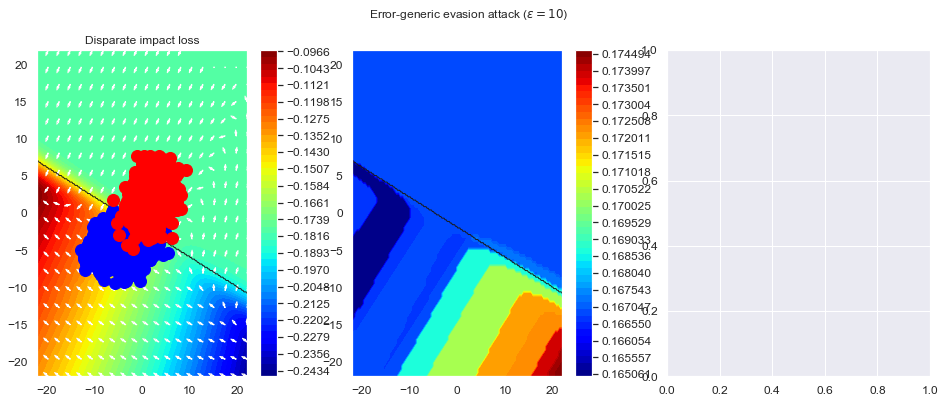

In [4]:
#!/usr/bin/env python
# coding: utf-8


from secml.ml.classifiers import CClassifierSVM, CClassifierLogistic
from secml.ml.kernels import CKernelRBF, CKernelLinear
from secml.ml.peval.metrics import CMetricAccuracy
from secml.data.splitter import CDataSplitterKFold

from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks import CAttackPoisoningLogisticRegression

import numpy as np
from secml.data import CDataset

from secml.figure import CFigure
from secml.ml.classifiers.loss import CLossClassification, CLossLogistic
from secml.array import CArray

from fairness.utils import load_data


class CLossDisparateImpact(CLossClassification):
    """Surrogate function of disparate impact.

    Attributes
    ----------
    class_type : 'log'
    suitable_for : 'classification'

    """
    __class_type = 'dimp_log'

    def __init__(self, _privileged_condition):
        self._privileged_condition = CArray(_privileged_condition)

    def unprivileged(self):
        """Give 1 to unprivileged, 0 to privileged"""
        y = CArray.zeros(self._privileged_condition.size)
        y[self._privileged_condition == 0] = 1
        return y

    def loss(self, y_true, score, pos_label=1):
        """Computes loss_priv-loss_unpriv, which is what we aim to max"""
        # give 1 to unpriv, 0 to priv
        y = self.unprivileged()
        p_priv = (y == 0).sum() / y.size
        p_unpriv = (y == 1).sum() / y.size
        # loss = (score >= 0) != y  # zero-one loss
        loss = CLossLogistic().loss(y_true=y, score=score)  # smoothed version
        loss[y == 1] *= -p_priv / p_unpriv  # rebalance class weights
        return loss

    def dloss(self, y_true, score, pos_label=1):
        """Computes the derivative of the loss vs score."""
        y = self.unprivileged()
        p_priv = (y == 0).sum() / y.size
        p_unpriv = (y == 1).sum() / y.size
        grad = CLossLogistic().dloss(y, score, pos_label)
        grad[y == 1] *= -p_priv / p_unpriv  # rebalance class weights
        return grad


class CDisparateImpact:
    """disparate impact."""

    def __init__(self, _privileged_condition, tr, ts, clf):
        self._privileged_condition = CArray(_privileged_condition)
        self.tr = tr
        self.ts = ts
        self.clf = clf

    def unprivileged(self):
        """Give 1 to unprivileged, 0 to privileged"""
        y = CArray.zeros(self._privileged_condition.size)
        y[self._privileged_condition == 0] = 1
        return y

    def objective_function(self, xc, yc):
        # retrain clf on poisoned data
        clf = self.clf.deepcopy()
        tr = self.tr.append(CDataset(xc, yc))
        clf.fit(tr)
        y_pred = clf.predict(self.ts.X)
        unpriv = self.unprivileged()
        return y_pred[unpriv == 1].mean() / y_pred[unpriv == 0].mean()


%matplotlib inline
random_state = 99

training_set, validation_set, test_set, \
privileged_condition_validation = load_data()

clf = CClassifierLogistic()
clf.fit(training_set)
clf2 = clf.deepcopy()
print("Training of classifier complete!")

n_poisoning_points = training_set.num_samples * 0.2

# Compute predictions on a test set
y_pred, scores = clf.predict(test_set.X, return_decision_function=True)

# Evaluate the accuracy of the classifier
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)
print("Accuracy on test set: {:.2%}".format(acc))

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 1000,
    'eps': 1e-6
}

pois_attack = CAttackPoisoningLogisticRegression(
    classifier=clf,
    training_data=training_set,
    surrogate_classifier=clf,
    surrogate_data=validation_set,
    val=validation_set,
    lb=validation_set.X.min(),
    ub=validation_set.X.max(),
    solver_params=solver_params,
    random_seed=random_state,
    init_type="random")

attack_loss = CLossDisparateImpact(privileged_condition_validation)
pois_attack._attacker_loss = attack_loss

pois_attack.n_points = n_poisoning_points

# this class plots the disparate impact as a function of xc
disp_impact = CDisparateImpact(
    privileged_condition_validation,
    tr=training_set,
    ts=validation_set,
    clf=clf)

fig = CFigure(width=16, height=6, markersize=12)
fig.subplot(1, 3, 1)  # surrogate DI
fig.sp.plot_fun(pois_attack._objective_function, plot_levels=False,
                multipoint=False, n_grid_points=100,
                grid_limits=[(-20, 20), (-20, 20)])
fig.sp.plot_fgrads(pois_attack._objective_function_gradient,
                   n_grid_points=20, grid_limits=[(-20, 20), (-20, 20)])
fig.sp.plot_decision_regions(clf, plot_background=False,
                             n_grid_points=200,
                             grid_limits=[(-20, 20), (-20, 20)])

fig.sp.plot_ds(training_set)
fig.sp.grid(grid_on=False)
fig.sp.title("Disparate impact loss")

fig.subplot(1, 3, 2)  # DI
pois_attack._attacker_loss = attack_loss
fig.sp.plot_fun(disp_impact.objective_function, plot_levels=False,
                multipoint=False, n_grid_points=100,
                grid_limits=[(-20, 20), (-20, 20)], yc=1)
fig.sp.plot_decision_regions(clf, plot_background=False,
                             n_grid_points=200,
                             grid_limits=[(-20, 20), (-20, 20)])



fig.subplot(1, 3, 3)  # DI

# Let's replicate the `l2` constraint used by the attack for visualization
from secml.optim.constraints import CConstraintL2
x0, y0 = test_set[5, :].X, test_set[5, :].Y  # Initial sample
dmax=10
constraint = CConstraintL2(center=x0, radius=dmax)

pois_attack2 = CAttackPoisoningLogisticRegression(
    classifier=clf2,
    training_data=training_set,
    surrogate_classifier=clf2,
    surrogate_data=validation_set,
    val=validation_set,
    lb=validation_set.X.min(),
    ub=validation_set.X.max(),
    solver_params=solver_params,
    random_seed=random_state,
    init_type="random")

attack_loss = CLossDisparateImpact(privileged_condition_validation)
pois_attack2._attacker_loss = attack_loss
"""

pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack2.run(test_set.X, test_set.Y)
print(pois_ds)



for i, (attack, adv_ds) in enumerate(
        [(pois_attack2, pois_ds)]):


    fig.subplot(1, 3, i + 2)

    # Convenience function for plotting the attack objective function
    fig.sp.plot_fun(attack._objective_function, plot_levels=False,
                    multipoint=False, n_grid_points=200,grid_limits=[(-20, 20), (-20, 20)])
    # Let's also plot the decision boundaries of the classifier
    fig.sp.plot_decision_regions(clf, plot_background=False, n_grid_points=200)

    # Construct an array with the original point and the adversarial example
    adv_path = x0.append(adv_ds.X, axis=0)

    # Convenience function for plotting the optimization sequence
    fig.sp.plot_path(attack.x_seq)

    # Convenience function for plotting a constraint
    fig.sp.plot_constraint(constraint)

    fig.sp.title(attack.class_type)
    fig.sp.grid(grid_on=False)
"""
fig.title(r"Error-generic evasion attack ($\varepsilon={:}$)".format(dmax))
#fig.sp.plot_ds(training_set)


generate_synthetic_data(plot_data=True, distrib_distance=np.array([5,5]), ax=fig.axes[1], title="")
generate_synthetic_data(plot_data=True, distrib_distance=np.array([5,5]), ax=fig.axes[2], title="")
fig.sp.grid(grid_on=False)
fig.sp.title("Disparate impact")
fig.show()

fig.savefig("error.pdf")



## 2. Creating custom Weighted CLoss to solve the optimization

In [5]:

from secml.ml.classifiers.loss import CLossClassification, CLossLogistic
from secml.array import CArray

In [6]:
class CLossDisparateImpact(CLossClassification):
    """Surrogate function of disparate impact.

    Attributes
    ----------
    class_type : 'log'
    suitable_for : 'classification'

    """
    __class_type = 'dimp_log'

    def __init__(self, _privileged_condition):
        self._privileged_condition = CArray(_privileged_condition)

    def unprivileged(self):
        """Give 1 to unprivileged, 0 to privileged"""
        y = CArray.zeros(self._privileged_condition.size)
        y[self._privileged_condition == 0] = 1
        return y

    def loss(self, y_true, score, pos_label=1):
        """Computes loss_priv-loss_unpriv, which is what we aim to max"""
        # give 1 to unpriv, 0 to priv
        y = self.unprivileged()
        p_priv = (y == 0).sum() / y.size
        p_unpriv = (y == 1).sum() / y.size
        # loss = (score >= 0) != y  # zero-one loss
        loss = CLossLogistic().loss(y_true=y, score=score)  # smoothed version
        loss[y == 1] *= -p_priv / p_unpriv  # rebalance class weights
        return loss

    def dloss(self, y_true, score, pos_label=1):
        """Computes the derivative of the loss vs score."""
        y = self.unprivileged()
        p_priv = (y == 0).sum() / y.size
        p_unpriv = (y == 1).sum() / y.size
        grad = CLossLogistic().dloss(y, score, pos_label)
        grad[y == 1] *= -p_priv / p_unpriv  # rebalance class weights
        return grad

In [7]:
def execute_adversarial_attack(surrogate_clf, training_set, validation_set, test_set, sensible_att_in_test, privileged_condition_validation, percentage_pois=0.75):

    metric = CMetricAccuracy()
    NUM_SAMPLES_TRAIN = training_set.num_samples
    n_poisoning_points = int(NUM_SAMPLES_TRAIN * percentage_pois) # Number of poisoning points to generate
    print("Creating {} poisoning samples ".format(n_poisoning_points))
    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.05,
        'eta_min': 0.05,
        'eta_max': None,
        'max_iter': 1000,
        'eps': 1e-6
    }


    pois_attack = CAttackPoisoningLogisticRegression(classifier=surrogate_clf,
                                      training_data=training_set,
                                      surrogate_classifier=surrogate_clf,
                                      surrogate_data=validation_set,
                                      val=validation_set,
                                      distance='l2',
                                      dmax=0.5,
                                      lb=validation_set.X.min(), ub=validation_set.X.max(),
                                      solver_params=solver_params,
                                      random_seed=random_state,
                                      init_type="random")

    pois_attack.n_points = n_poisoning_points
    
    dimp_loss = CLossDisparateImpact(privileged_condition_validation)
    pois_attack._attacker_loss = dimp_loss

    # Run the poisoning attack
    print("Attack started...")
    pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(test_set.X, test_set.Y)
    print("Attack complete!")

    
    pois_tr = training_set.deepcopy().append(pois_ds)  # Join the training set with the poisoning points
   
    return pois_ds, pois_tr
    

## 3. Helper functions

In [8]:
def calculate_disparate_impact(y,sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=False):
    
    privileged = y[sensible_att_vals == privileged_classes]
    unprivileged = y[sensible_att_vals != privileged_classes]
    
    unprivileged_favorable = unprivileged[unprivileged==favorable_output]
    privileged_favorable = privileged[privileged==favorable_output]
    
    n1 =  (len(unprivileged_favorable)/ len(unprivileged))
    n2 = (len(privileged_favorable)/ len(privileged))
    
    if verbose:
        print("\tN1: ", n1)
        print("\tN2: ", n2)
        
        #print("privileged: ", privileged)
        #print("unprivileged: ", unprivileged)
        
     
    
    disparate_impact = n1 / (max(n2,0.1)) 
    return disparate_impact

def calculate_error_rate_ratio(y_true, y_pred,sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=True):
    privileged_y_true = y_true[sensible_att_vals == privileged_classes]
    unprivileged_y_true = y_true[sensible_att_vals != privileged_classes]
    
    privileged_y_pred = y_pred[sensible_att_vals == privileged_classes]
    unprivileged_y_pred = y_pred[sensible_att_vals != privileged_classes]
    
    privileged_num_errors = len(privileged_y_true) - (len(np.where(np.isclose(privileged_y_true, privileged_y_pred))[0]))
    unprivileged_num_errors = len(unprivileged_y_true) - (len(np.where(np.isclose(unprivileged_y_true, unprivileged_y_pred))[0]))
    
    if verbose:
        print("\tN1: ", n1)
        print("\tN2: ", n2)
        
    
        
    error_rate = (unprivileged_num_errors / len(unprivileged_y_true)) / (privileged_num_errors / len(privileged_y_true))
    return error_rate
    

def get_false_positive_rate(y_true, y_pred, favorable_output):
    _tmp = y_pred[y_true!=favorable_output]
    
    fp = _tmp[_tmp == favorable_output]
    if len(_tmp) == 0:
        return 0
    
    return len(fp) / len(_tmp)
    
    
def get_false_negative_rate(y_true, y_pred, favorable_output):
    _tmp = y_pred[y_true==favorable_output]
    
    fn = _tmp[_tmp != favorable_output]
    
    if len(_tmp) == 0:
        return 0
    
    return len(fn) / len(_tmp)

def get_error_rates(y_true, y_pred, sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=False):
    privileged_y_true = y_true[sensible_att_vals == privileged_classes]
    unprivileged_y_true = y_true[sensible_att_vals != privileged_classes]
    
    privileged_y_pred = y_pred[sensible_att_vals == privileged_classes]
    unprivileged_y_pred = y_pred[sensible_att_vals != privileged_classes]
    """
    privileged_num_errors = len(privileged_y_true) - (len(np.where(np.isclose(privileged_y_true, privileged_y_pred))[0]))
    unprivileged_num_errors = len(unprivileged_y_true) - (len(np.where(np.isclose(unprivileged_y_true, unprivileged_y_pred))[0]))
    
    if verbose:
        print("\tN1: ", n1)
        print("\tN2: ", n2)

        error_rate = (unprivileged_num_errors / len(unprivileged_y_true)) / (privileged_num_errors / len(privileged_y_true))
    """
    
    FNR_privileged = get_false_negative_rate(privileged_y_true, privileged_y_pred, favorable_output)
    FNR_unprivileged = get_false_negative_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    
    FPR_privileged = get_false_positive_rate(privileged_y_true, privileged_y_pred, favorable_output)
    FPR_unprivileged = get_false_positive_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    
    
    if verbose:
        print("\tFNR_1: ", FNR_privileged)
        print("\tFNR_2: ", FNR_unprivileged)
        print("\tFPR_1: ", FPR_privileged)
        print("\tFPR_2: ", FPR_unprivileged)
    
    FNR = -1
    FPR = -1
    
    try:
        FNR = FNR_unprivileged / FNR_privileged
    except:
        pass
    
    try:
        FPR = FPR_unprivileged / FPR_privileged
    except:
        pass
        

    return ({"FNR": FNR, "FNR_privileged":FNR_privileged, "FNR_unprivileged":FNR_unprivileged, "FNR": 1}, {"FPR":FPR, "FPR_privileged":FPR_privileged, "FPR_unprivileged":FPR_unprivileged})



def train_LogReg(training_set, test_set):

    
    # Metric to use for training and performance evaluation
    # Creation of the multiclass classifier
    metric = CMetricAccuracy()

    #clf = CClassifierSVM(kernel=CKernelRBF()) # Radial Basis Function (RBF) kernel.
    #clf = CClassifierSVM(kernel=CKernelLinear()) # Linear kernel.
    clf = CClassifierLogistic()
    # Parameters for the Cross-Validation procedure
    xval_params = {'C': [1, 10]}#, 'kernel.gamma': [0.1]}#, 5, 10, 25, 50, 100]}

    # Let's create a 3-Fold data splitter
    
    xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

    # Select and set the best training parameters for the classifier
    print("Estimating the best training parameters...")
    best_params = clf.estimate_parameters(
        dataset=training_set,
        parameters=xval_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )

    print("The best training parameters are: ", best_params)

    # We can now fit the classifier
    clf.fit(training_set)
    print("Training of classifier complete!")

    # Compute predictions on a test set
    y_pred = clf.predict(test_set.X)

    # Evaluate the accuracy of the classifier
    acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)

    print("Accuracy on test set: {:.2%}".format(acc))
    
    return clf, acc

def train_SVM(training_set, test_set):

    
    # Metric to use for training and performance evaluation
    # Creation of the multiclass classifier
    metric = CMetricAccuracy()

    #clf = CClassifierSVM(kernel=CKernelRBF()) # Radial Basis Function (RBF) kernel.
    clf = CClassifierSVM(kernel=CKernelLinear()) # Linear kernel.
    #clf = CClassifierLogistic()
    # Parameters for the Cross-Validation procedure
    xval_params = {'C': [1, 10]}#,'kernel.gamma': [0.1, 5, 10, 25, 50, 100]}

    # Let's create a 3-Fold data splitter
    
    xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

    # Select and set the best training parameters for the classifier
    print("Estimating the best training parameters...")
    best_params = clf.estimate_parameters(
        dataset=training_set,
        parameters=xval_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )

    print("The best training parameters are: ", best_params)

    # We can now fit the classifier
    clf.fit(training_set)
    print("Training of classifier complete!")

    # Compute predictions on a test set
    y_pred = clf.predict(test_set.X)

    # Evaluate the accuracy of the classifier
    acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)

    print("Accuracy on test set: {:.2%}".format(acc))
    
    return clf, acc
    

In [9]:
def execute_adversarial_attack(surrogate_clf, training_set, validation_set, test_set, sensible_att_in_test, privileged_condition_validation, percentage_pois=0.05):

    metric = CMetricAccuracy()
    NUM_SAMPLES_TRAIN = training_set.num_samples
    n_poisoning_points = int(NUM_SAMPLES_TRAIN * percentage_pois) # Number of poisoning points to generate
    print("Creating {} poisoning samples ".format(n_poisoning_points))
    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.05,
        'eta_min': 0.05,
        'eta_max': None,
        'max_iter': 1000,
        'eps': 1e-6
    }


    pois_attack = CAttackPoisoningLogisticRegression(classifier=surrogate_clf,
                                      training_data=training_set,
                                      surrogate_classifier=surrogate_clf,
                                      surrogate_data=validation_set,
                                      val=validation_set,
                                      distance='l2',
                                      dmax=0.5,
                                      lb=validation_set.X.min(), ub=validation_set.X.max(),
                                      solver_params=solver_params,
                                      random_seed=random_state,
                                      init_type="random")

    pois_attack.n_points = n_poisoning_points
    
    dimp_loss = CLossDisparateImpact(privileged_condition_validation)
    
    pois_attack._attacker_loss = dimp_loss

    # Run the poisoning attack
    print("Attack started...")
    pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(test_set.X, test_set.Y)
    print("Attack complete!")

    
    pois_tr = training_set.deepcopy().append(pois_ds)  # Join the training set with the poisoning points
   
    return pois_ds, pois_tr
    

In [10]:
from sklearn.model_selection import train_test_split
N=9 #Max euclidean distance between average of distributions

dimp_in_data = []
euc_distances = []
dimp_scenarios = []

n=9
    
## Generating data
euc_dist = n
i = np.sqrt((euc_dist**2)/2)
X,y,X_control = generate_synthetic_data(False, np.array([i,i]))
formatted_X=np.array([X[:,0], X[:,1], X_control['s1']]).T ## Concatenating X with sensible att

sec_ml_dataset_all = CDataset(X, y)
sensible_att_all = X_control['s1']

euc_distances.append(n)
dimp_in_data.append(calculate_disparate_impact(sec_ml_dataset_all.Y.get_data(), sensible_att_all)) 

## Splitting data. 
X_train_val, X_test, y_train_val, y_test = train_test_split(formatted_X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=random_state)

training = CDataset(X_train[:,:2], y_train)
training_sensible_att = X_train[:,2]

validation = CDataset(X_val[:,:2], y_val)
validation_sensible_att = X_val[:,2]
val_lambda = np.zeros(validation.num_samples)

## Creating lambda vector
val_lambda[np.where((validation_sensible_att==0) & (y_val==0))[0]] == 1 ## Unprivileged denied
val_lambda[np.where((validation_sensible_att==0) & (y_val==1))[0]] == 1 ## Unprivileged granted
val_lambda[np.where((validation_sensible_att==1) & (y_val==0))[0]] == -1 ## Privileged denied
val_lambda[np.where((validation_sensible_att==1) & (y_val==1))[0]] == -1 ## Privileged granted

test = CDataset(X_test[:,:2], y_test)
test_sensible_att = X_test[:,2]


## GENERATING DATA FOR WHITE BOX ATTACK
X2,y2,X_control2 = generate_synthetic_data(False, np.array([i,i]))
formatted_X2=np.array([X2[:,0], X2[:,1], X_control2['s1']]).T ## Concatenating X with sensible att

sec_ml_dataset_all2 = CDataset(X2, y2)
sensible_att_all2 = X_control2['s1']

## Splitting data. 
X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(formatted_X2, y2, test_size=0.2, random_state=random_state)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train_val2, y_train_val2, test_size=0.5, random_state=random_state)

training2 = CDataset(X_train2[:,:2], y_train2)
training_sensible_att2 = X_train2[:,2]

validation2 = CDataset(X_val2[:,:2], y_val2)
validation_sensible_att2 = X_val2[:,2]
val_lambda2 = np.zeros(validation2.num_samples)

## Creating lambda vector
val_lambda2[np.where((validation_sensible_att2==0) & (y_val2==0))[0]] == 1 ## Unprivileged denied
val_lambda2[np.where((validation_sensible_att2==0) & (y_val2==1))[0]] == 1 ## Unprivileged granted
val_lambda2[np.where((validation_sensible_att2==1) & (y_val2==0))[0]] == -1 ## Privileged denied
val_lambda2[np.where((validation_sensible_att2==1) & (y_val2==1))[0]] == -1 ## Privileged granted

test2 = CDataset(X_test2[:,:2], y_test)
test_sensible_att2 = X_test2[:,2]

scenario = {
    "name": "Use case 4 - {}".format(n),
    "description": "Disparate impact attack. \n Euclidean distance between group averages: {}\n".format(n),
    "training": training,
    "training_sensible_att" : training_sensible_att,
    "validation" : validation,
    "validation_sensible_att" : validation_sensible_att,
    "lambda_validation" : val_lambda,
    "test": test,
    "test_sensible_att" : test_sensible_att,
    "all_data" : sec_ml_dataset_all,
    "all_sensible_att" : sensible_att_all,        
    "black_box_training": training2,
    "black_box_training_sensible_att" : training_sensible_att2,
    "black_box_validation" : validation2,
    "black_box_validation_sensible_att" : validation_sensible_att2,
    "black_box_lambda_validation" : val_lambda2,
    "black_box_test": test2,
    "black_box_test_sensible_att" : test_sensible_att2,
    "black_box_all_data" : sec_ml_dataset_all2,
    "black_box_all_sensible_att" : sensible_att_all2,
}

dimp_scenarios.append(scenario)


In [11]:
scenario = dimp_scenarios[0]

training_set = scenario['training']
validation_set = scenario['training']
test_set = scenario['test']
privileged_condition_validation = np.ones(scenario['validation'].num_samples)
privileged_condition_validation[scenario["validation_sensible_att"] == 0] = -1



x0, y0 = test_set[5, :].X, test_set[5, :].Y
dmax=0.5

percentage_pois = 0.05

# Metric to use for training and performance evaluation
# Creation of the multiclass classifier
metric = CMetricAccuracy()


surrogate_clf = CClassifierLogistic()
# Parameters for the Cross-Validation procedure
xval_params = {'C': [1, 10]}#, 'kernel.gamma': [0.1]}#, 5, 10, 25, 50, 100]}

# Let's create a 3-Fold data splitter

xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Select and set the best training parameters for the classifier
print("Estimating the best training parameters...")
best_params = surrogate_clf.estimate_parameters(
    dataset=training_set,
    parameters=xval_params,
    splitter=xval_splitter,
    metric='accuracy',
    perf_evaluator='xval'
)

n_poisoning_points = training_set.num_samples * 0.02

print("The best training parameters are: ", best_params)

# We can now fit the classifier
surrogate_clf.fit(training_set)
print("Training of classifier complete!")

# Compute predictions on a test set
y_pred, scores = surrogate_clf.predict(test_set.X, return_decision_function=True)
print(scores)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))
print(y_pred)


# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 1000,
    'eps': 1e-6
}


pois_attack = CAttackPoisoningLogisticRegression(classifier=surrogate_clf,
                                  training_data=training_set,
                                  surrogate_classifier=surrogate_clf,
                                  surrogate_data=validation_set,
                                  val=validation_set,
                                  lb=validation_set.X.min(), ub=validation_set.X.max(),
                                  solver_params=solver_params,
                                  random_seed=random_state,
                                  init_type="random")

pois_attack.n_points = n_poisoning_points

dimp_loss = CLossDisparateImpact(validation_sensible_att)
pois_attack._attacker_loss = dimp_loss

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(test_set.X, test_set.Y)
print("Attack complete!")


#pois_tr = training_set.deepcopy().append(pois_ds)


from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=16, height=6, markersize=12)


fig.subplot(1, 2, 1)

# Convenience function for plotting the attack objective function
fig.sp.plot_fun(pois_attack._objective_function, plot_levels=False, multipoint=False, n_grid_points=100,
               grid_limits=[(-20, 20), (-20, 20)])

# Let's also plot the decision boundaries of the classifier
fig.subplot(1, 2, 2)
fig.sp.plot_decision_regions(surrogate_clf, plot_background=True, n_grid_points=200,
                            grid_limits=[(-20, 20), (-20, 20)])
fig.sp.plot_ds(training_set)
fig.sp.title(pois_attack.class_type)
fig.sp.grid(grid_on=False)

fig.title(r"Error-generic evasion attack ($\varepsilon={:}$)".format(dmax))

fig.show()


Estimating the best training parameters...
The best training parameters are:  {'C': 1}
Training of classifier complete!
CArray([[-1.715825  1.715825]
 [-8.371822  8.371822]
 [ 2.817901 -2.817901]
 ...
 [ 3.57195  -3.57195 ]
 [-5.241351  5.241351]
 [ 4.514901 -4.514901]])
Accuracy on test set: 98.00%
CArray([1 1 0 ... 0 1 0])


ValueError: following classes have the same class type. Fix before continue. [('CLossDisparateImpact', 'dimp_log'), ('CLossDisparateImpact', 'dimp_log')]

In [ ]:
pois_ds

In [ ]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=16, height=6, markersize=12)

# Let's replicate the `l2` constraint used by the attack for visualization
from secml.optim.constraints import CConstraintL2
constraint = CConstraintL2(center=x0, radius=dmax)

for i, (attack, adv_ds) in enumerate(
        [(pois_attack, pois_ds)]):

    fig.subplot(1, 2, i + 1)

    # Convenience function for plotting the attack objective function
    fig.sp.plot_fun(attack._objective_function, plot_levels=False,
                    multipoint=False, n_grid_points=200)
    # Let's also plot the decision boundaries of the classifier
    fig.sp.plot_decision_regions(surrogate_clf, plot_background=False, n_grid_points=200)

    # Construct an array with the original point and the adversarial example
    adv_path = x0.append(adv_ds.X, axis=0)

    # Convenience function for plotting the optimization sequence
    fig.sp.plot_path(attack.x_seq)

    # Convenience function for plotting a constraint
    fig.sp.plot_constraint(constraint)

    fig.sp.title(attack.class_type)
    fig.sp.grid(grid_on=False)

fig.title(r"Error-generic evasion attack ($\varepsilon={:}$)".format(dmax))

fig.show()
